#LGB 0.636 mse
#0.639 mae

# 0.50151896000 lgb

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131183 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.6-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.6-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.6-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [54]:
!mkdir -p GuodongDrive
!google-drive-ocamlfuse GuodongDrive
import os
os.chdir("GuodongDrive")
os.chdir("ccf/carsale")
!ls

0825ccf_carsale.csv	   baseline2.ipynb
0825ccf_car_sales_lgb.csv  catboost_info
083101_car_sale.csv	   ccf_car_sales082601.csv
083101sub.csv		   ccf_car_sales082602.csv
083103_car_sale.csv	   ccf_car_sales.csv
083103sub.csv		   ccf_car_sales_lgb.csv
090101car_sales.csv	   evaluation_public.csv
090102car_sales.csv	   evaluation_public_new.csv
090103car_sales.csv	   evaluation_public_xishao.csv
090201car_sales.csv	   guize1-new.ipynb
baseline082601.ipynb	   GuodongDrive
baseline082701.ipynb	   ronghe_car_sales.csv
baseline082702.ipynb	   submit_example.csv
baseline082703.ipynb	   train_sales_data.csv
baseline082704.ipynb	   train_sales_new.csv
baseline083101.ipynb	   train_search_data.csv
baseline083102.ipynb	   train_user_reply_data.csv
baseline090101.ipynb	   Untitled0.ipynb
baseline1_copy.ipynb	   xishao_car_sale.csv
baseline1.ipynb		   统计_car_sales.csv


In [4]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
import lightgbm as lgb
import catboost as ctb

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [5]:
from sklearn import linear_model, svm, gaussian_process
from sklearn.ensemble import RandomForestRegressor

思路：  
- 这种popularity	carCommentVolum	newsReplyVolum我感觉都是增长的，可以预测出来,我们可以单独用模型将接下来四个月份的这三个指标预测出来

- 在统计分数的时候所用的验证集，已经作为模型的验证集训练过，所以得到的分数会偏高
应该用split先将train_set分为train和valid，再去用17年最后的四个月作为统计分数的指标

- 可以用KFold进行train_set和valid_set的训练

- 他在训练时将特征model和type换成另一种表现方式，不妨把这种表现方式设为新的特征，model和type依然保留作为特征

-预测流量指数考虑clfs = {
        'svm':svm.SVR(), 
        'RandomForestRegressor':RandomForestRegressor(n_estimators=400),
        'BayesianRidge':linear_model.BayesianRidge()
       }
for clf in clfs:
    try:
        clfs[clf].fit(X_train, y_train)
        y_pred = clfs[clf].predict(X_test)
        print(clf + " cost:" + str(np.sum(y_pred-y_test)/len(y_pred)) )

In [6]:
train_sales_data = pd.read_csv('train_sales_data.csv')
train_search_data = pd.read_csv('train_search_data.csv')
train_user_reply_data = pd.read_csv('train_user_reply_data.csv')
test = pd.read_csv('evaluation_public.csv')

In [50]:
test.shape

(5280, 7)

In [7]:

test2 = pd.read_csv('evaluation_public_new.csv')


In [36]:
# data = pd.concat([train_sales_data, test], ignore_index=True)
# data = data.merge(train_search_data, 'left', on=['province', 'adcode', 'model', 'regYear', 'regMonth'])
# data = data.merge(train_user_reply_data, 'left', on=['model', 'regYear', 'regMonth'])
# data.head(10)

,adcode,bodyType,forecastVolum,id,model,province,regMonth,regYear,salesVolume,popularity,carCommentVolum,newsReplyVolum
0,310000,SUV,NaN,NaN,3c974920a76ac9c1,上海,1,2016,292.0,1479.0,11.0,106.0
1,530000,SUV,NaN,NaN,3c974920a76ac9c1,云南,1,2016,466.0,1594.0,11.0,106.0
2,150000,SUV,NaN,NaN,3c974920a76ac9c1,内蒙古,1,2016,257.0,1479.0,11.0,106.0
3,110000,SUV,NaN,NaN,3c974920a76ac9c1,北京,1,2016,408.0,2370.0,11.0,106.0
4,510000,SUV,NaN,NaN,3c974920a76ac9c1,四川,1,2016,610.0,3562.0,11.0,106.0
5,340000,SUV,NaN,NaN,3c974920a76ac9c1,安徽,1,2016,206.0,1314.0,11.0,106.0
6,370000,SUV,NaN,NaN,3c974920a76ac9c1,山东,1,2016,503.0,3476.0,11.0,106.0
7,140000,SUV,NaN,NaN,3c974920a76ac9c1,山西,1,2016,236.0,1422.0,11.0,106.0
8,440000,SUV,NaN,NaN,3c974920a76ac9c1,广东,1,2016,3635.0,7182.0,11.0,106.0
9,450000,SUV,NaN,NaN,3c974920a76ac9c1,广西,1,2016,450.0,1163.0,11.0,106.0


In [8]:

# data = pd.concat([train_sales_data, test], ignore_index=True)
data = train_sales_data
data['id'] = 0
data = data.merge(train_search_data, 'left', on=['province', 'adcode', 'model', 'regYear', 'regMonth'])
data = data.merge(train_user_reply_data, 'left', on=['model', 'regYear', 'regMonth'])
data = pd.concat([data, test2], ignore_index=True)
#data = data.(test2, 'left', on=['id','province', 'adcode', 'model', 'regYear', 'regMonth','popularity','newsReplyVolum','carCommentVolum'])
# data = data.merge(train_user_reply_data, 'left', on=['model', 'regYear', 'regMonth','newsReplyVolum','carCommentVolum'])
# data = pd.DataFrame(data)
data.head()

,adcode,bodyType,carCommentVolum,forecastVolum,id,model,newsReplyVolum,popularity,province,regMonth,regYear,salesVolume
0,310000,SUV,11.0,NaN,0,3c974920a76ac9c1,106.0,1479.0,上海,1,2016,292.0
1,530000,SUV,11.0,NaN,0,3c974920a76ac9c1,106.0,1594.0,云南,1,2016,466.0
2,150000,SUV,11.0,NaN,0,3c974920a76ac9c1,106.0,1479.0,内蒙古,1,2016,257.0
3,110000,SUV,11.0,NaN,0,3c974920a76ac9c1,106.0,2370.0,北京,1,2016,408.0
4,510000,SUV,11.0,NaN,0,3c974920a76ac9c1,106.0,3562.0,四川,1,2016,610.0


In [9]:
data.tail()

,adcode,bodyType,carCommentVolum,forecastVolum,id,model,newsReplyVolum,popularity,province,regMonth,regYear,salesVolume
36955,350000,NaN,146.0,NaN,5364,a9a43d1a7ecbe75d,1033.3,485.0,福建,4,2018,NaN
36956,210000,NaN,146.0,NaN,5365,a9a43d1a7ecbe75d,1033.3,795.4,辽宁,4,2018,NaN
36957,500000,NaN,146.0,NaN,5366,a9a43d1a7ecbe75d,1033.3,446.1,重庆,4,2018,NaN
36958,610000,NaN,146.0,NaN,5367,a9a43d1a7ecbe75d,1033.3,950.8,陕西,4,2018,NaN
36959,230000,NaN,146.0,NaN,5368,a9a43d1a7ecbe75d,1033.3,523.4,黑龙江,4,2018,NaN


In [10]:
day_map = {1:31,2:28,3:31,4:30,5:31,6:30,7:31,8:31,9:30,10:31,11:30,12:31}
data['daycount']=data['regMonth'].map(day_map)
data.loc[(data.regMonth==2)&(data.regYear==2016),'daycount']=29

 **每年二月份买车都比较少，感觉应该单独预测**

**每年十二月份比较多，感觉可以去掉**

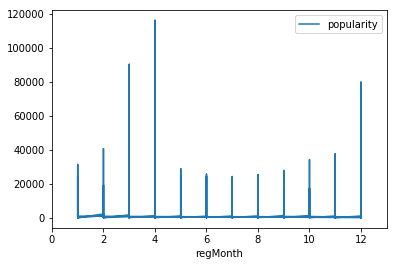

In [0]:
data.plot(x= 'regMonth',y = 'popularity',xlim=(0, 13))

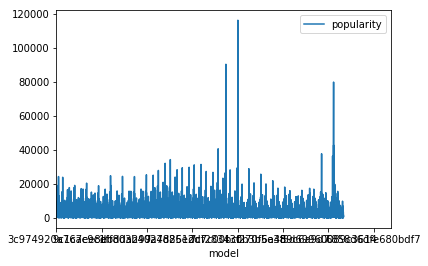

In [0]:
data.plot(x= 'model',y = 'popularity')

In [0]:
data.tail(5)

,adcode,bodyType,forecastVolum,id,model,province,regMonth,regYear,salesVolume,popularity,carCommentVolum,newsReplyVolum
36955,350000,NaN,NaN,5364.0,a9a43d1a7ecbe75d,福建,4,2018,NaN,NaN,NaN,NaN
36956,210000,NaN,NaN,5365.0,a9a43d1a7ecbe75d,辽宁,4,2018,NaN,NaN,NaN,NaN
36957,500000,NaN,NaN,5366.0,a9a43d1a7ecbe75d,重庆,4,2018,NaN,NaN,NaN,NaN
36958,610000,NaN,NaN,5367.0,a9a43d1a7ecbe75d,陕西,4,2018,NaN,NaN,NaN,NaN
36959,230000,NaN,NaN,5368.0,a9a43d1a7ecbe75d,黑龙江,4,2018,NaN,NaN,NaN,NaN


In [11]:
data['label'] = data['salesVolume']
data['id'] = data['id'].fillna(0).astype(int)
del data['salesVolume'], data['forecastVolum']
data['bodyType_2'] = data['model'].map(train_sales_data.drop_duplicates('model').set_index('model')['bodyType'])
data['model'].head()
#一种model可能对应多种type

0    3c974920a76ac9c1
1    3c974920a76ac9c1
2    3c974920a76ac9c1
3    3c974920a76ac9c1
4    3c974920a76ac9c1
Name: model, dtype: object

In [12]:
data['model_2'] = data['model']

In [0]:
data.head(10)

,Mean_day,Median_Year,adcode,bodyType,daycount,id,model,perday_sales_y,province,quarter_mean,quarter_ratio,quarter_sum,qushi_v,regMonth,regYear,sum_Year,popularity,carCommentVolum,newsReplyVolum,label,bodyType_2,model_2
0,8.672244,8.741935,310000,SUV,31.0,0,3c974920a76ac9c1,9.419355,上海,8.153133,0.201343,24.459399,10.448315,1,2016,121.481106,1479.0,11.0,106.0,292.0,SUV,3c974920a76ac9c1
1,10.373087,9.935484,530000,SUV,31.0,0,3c974920a76ac9c1,15.032258,云南,10.415647,0.215815,31.246941,13.988925,1,2016,144.785620,1594.0,11.0,106.0,466.0,SUV,3c974920a76ac9c1
2,6.085886,6.032258,150000,SUV,31.0,0,3c974920a76ac9c1,8.290323,内蒙古,6.392288,0.225216,19.176863,6.243070,1,2016,85.148770,1479.0,11.0,106.0,257.0,SUV,3c974920a76ac9c1
3,12.069268,11.967742,110000,SUV,31.0,0,3c974920a76ac9c1,13.161290,北京,10.118650,0.179761,30.355951,17.464397,1,2016,168.868230,2370.0,11.0,106.0,408.0,SUV,3c974920a76ac9c1
4,13.703535,11.612903,510000,SUV,31.0,0,3c974920a76ac9c1,19.677419,四川,13.983315,0.221070,41.949944,14.592390,1,2016,189.758856,3562.0,11.0,106.0,610.0,SUV,3c974920a76ac9c1
5,5.093156,4.967742,340000,SUV,31.0,0,3c974920a76ac9c1,6.645161,安徽,5.286244,0.222801,15.858732,6.049800,1,2016,71.178770,1314.0,11.0,106.0,206.0,SUV,3c974920a76ac9c1
6,13.616982,13.616982,370000,SUV,31.0,0,3c974920a76ac9c1,16.225806,山东,12.822766,0.201787,38.468298,16.811525,1,2016,190.637746,3476.0,11.0,106.0,503.0,SUV,3c974920a76ac9c1
7,6.693252,6.693252,140000,SUV,31.0,0,3c974920a76ac9c1,7.612903,山西,6.104190,0.195427,18.312570,8.537750,1,2016,93.705525,1422.0,11.0,106.0,236.0,SUV,3c974920a76ac9c1
8,82.883716,77.645161,440000,SUV,31.0,0,3c974920a76ac9c1,117.258065,广东,75.680386,0.196550,227.041157,115.730347,1,2016,1155.133475,7182.0,11.0,106.0,3635.0,SUV,3c974920a76ac9c1
9,11.049503,11.049503,450000,SUV,31.0,0,3c974920a76ac9c1,14.516129,广西,11.144605,0.216130,33.433815,14.530959,1,2016,154.693035,1163.0,11.0,106.0,450.0,SUV,3c974920a76ac9c1


In [0]:
data.tail(10)

,Mean_day,Median_Year,adcode,bodyType,daycount,id,model,perday_sales_y,province,quarter_mean,quarter_ratio,quarter_sum,qushi_v,regMonth,regYear,sum_Year,popularity,carCommentVolum,newsReplyVolum,label,bodyType_2,model_2
36950,NaN,NaN,130000,NaN,NaN,5359,a9a43d1a7ecbe75d,NaN,河北,NaN,NaN,NaN,NaN,4,2018,NaN,NaN,NaN,NaN,NaN,SUV,a9a43d1a7ecbe75d
36951,NaN,NaN,410000,NaN,NaN,5360,a9a43d1a7ecbe75d,NaN,河南,NaN,NaN,NaN,NaN,4,2018,NaN,NaN,NaN,NaN,NaN,SUV,a9a43d1a7ecbe75d
36952,NaN,NaN,330000,NaN,NaN,5361,a9a43d1a7ecbe75d,NaN,浙江,NaN,NaN,NaN,NaN,4,2018,NaN,NaN,NaN,NaN,NaN,SUV,a9a43d1a7ecbe75d
36953,NaN,NaN,420000,NaN,NaN,5362,a9a43d1a7ecbe75d,NaN,湖北,NaN,NaN,NaN,NaN,4,2018,NaN,NaN,NaN,NaN,NaN,SUV,a9a43d1a7ecbe75d
36954,NaN,NaN,430000,NaN,NaN,5363,a9a43d1a7ecbe75d,NaN,湖南,NaN,NaN,NaN,NaN,4,2018,NaN,NaN,NaN,NaN,NaN,SUV,a9a43d1a7ecbe75d
36955,NaN,NaN,350000,NaN,NaN,5364,a9a43d1a7ecbe75d,NaN,福建,NaN,NaN,NaN,NaN,4,2018,NaN,NaN,NaN,NaN,NaN,SUV,a9a43d1a7ecbe75d
36956,NaN,NaN,210000,NaN,NaN,5365,a9a43d1a7ecbe75d,NaN,辽宁,NaN,NaN,NaN,NaN,4,2018,NaN,NaN,NaN,NaN,NaN,SUV,a9a43d1a7ecbe75d
36957,NaN,NaN,500000,NaN,NaN,5366,a9a43d1a7ecbe75d,NaN,重庆,NaN,NaN,NaN,NaN,4,2018,NaN,NaN,NaN,NaN,NaN,SUV,a9a43d1a7ecbe75d
36958,NaN,NaN,610000,NaN,NaN,5367,a9a43d1a7ecbe75d,NaN,陕西,NaN,NaN,NaN,NaN,4,2018,NaN,NaN,NaN,NaN,NaN,SUV,a9a43d1a7ecbe75d
36959,NaN,NaN,230000,NaN,NaN,5368,a9a43d1a7ecbe75d,NaN,黑龙江,NaN,NaN,NaN,NaN,4,2018,NaN,NaN,NaN,NaN,NaN,SUV,a9a43d1a7ecbe75d


In [0]:
range(data['model_2'].nunique())

range(0, 60)

In [13]:
for i in ['bodyType_2', 'model_2']:
    data[i] = data[i].map(dict(zip(data[i].unique(), range(data[i].nunique()))))#用这个函数可以查看数据有多少个不同值。

data.head(10)

,adcode,bodyType,carCommentVolum,id,model,newsReplyVolum,popularity,province,regMonth,regYear,daycount,label,bodyType_2,model_2
0,310000,SUV,11.0,0,3c974920a76ac9c1,106.0,1479.0,上海,1,2016,31,292.0,0,0
1,530000,SUV,11.0,0,3c974920a76ac9c1,106.0,1594.0,云南,1,2016,31,466.0,0,0
2,150000,SUV,11.0,0,3c974920a76ac9c1,106.0,1479.0,内蒙古,1,2016,31,257.0,0,0
3,110000,SUV,11.0,0,3c974920a76ac9c1,106.0,2370.0,北京,1,2016,31,408.0,0,0
4,510000,SUV,11.0,0,3c974920a76ac9c1,106.0,3562.0,四川,1,2016,31,610.0,0,0
5,340000,SUV,11.0,0,3c974920a76ac9c1,106.0,1314.0,安徽,1,2016,31,206.0,0,0
6,370000,SUV,11.0,0,3c974920a76ac9c1,106.0,3476.0,山东,1,2016,31,503.0,0,0
7,140000,SUV,11.0,0,3c974920a76ac9c1,106.0,1422.0,山西,1,2016,31,236.0,0,0
8,440000,SUV,11.0,0,3c974920a76ac9c1,106.0,7182.0,广东,1,2016,31,3635.0,0,0
9,450000,SUV,11.0,0,3c974920a76ac9c1,106.0,1163.0,广西,1,2016,31,450.0,0,0


zip() 函数用于将可迭代的对象作为参数，

将对象中对应的元素打包成一个个元组，

然后返回由这些元组组成的列表。

如果各个迭代器的元素个数不一致，则返回列表长度与最短的对象相同，

a = [1,2,3]

 b = [4,5,6]

 c = [4,5,6,7,8]

 zipped = zip(a,b)  # 打包为元组的列表

[(1, 4), (2, 5), (3, 6)]

zip(a,c)              # 元素个数与最短的列表一致

[(1, 4), (2, 5), (3, 6)]

In [14]:
data['mt'] = (data['regYear'] - 2016) * 12 + data['regMonth']

# 'popularity', 'carCommentVolum', 'newsReplyVolum','label'/

shift_feat = []

data['model_adcode'] = data['adcode'] + data['model_2']
data['model_adcode_mt'] = data['model_adcode'] * 100 + data['mt']
for i in [11]:
    i = i + 1
    shift_feat.append('shift_model_adcode_mt_label_{0}'.format(i))
    data['model_adcode_mt_{0}'.format(i)] = data['model_adcode_mt'] + i
    data_last = data[~data.label.isnull()].set_index('model_adcode_mt_{0}'.format(i))
    data['shift_model_adcode_mt_label_{0}'.format(i)] = data['model_adcode_mt'].map(data_last['label'])

shift_feat

['shift_model_adcode_mt_label_12']

In [0]:
data.head(10)

,Mean_day,Median_Year,adcode,bodyType,daycount,id,model,perday_sales_y,province,quarter_mean,quarter_ratio,quarter_sum,qushi_v,regMonth,regYear,sum_Year,popularity,carCommentVolum,newsReplyVolum,label,bodyType_2,model_2,mt,model_adcode,model_adcode_mt,model_adcode_mt_12,shift_model_adcode_mt_label_12
0,8.672244,8.741935,310000,SUV,31.0,0,3c974920a76ac9c1,9.419355,上海,8.153133,0.201343,24.459399,10.448315,1,2016,121.481106,1479.0,11.0,106.0,292.0,0,0,1,310000,31000001,31000013,NaN
1,10.373087,9.935484,530000,SUV,31.0,0,3c974920a76ac9c1,15.032258,云南,10.415647,0.215815,31.246941,13.988925,1,2016,144.785620,1594.0,11.0,106.0,466.0,0,0,1,530000,53000001,53000013,NaN
2,6.085886,6.032258,150000,SUV,31.0,0,3c974920a76ac9c1,8.290323,内蒙古,6.392288,0.225216,19.176863,6.243070,1,2016,85.148770,1479.0,11.0,106.0,257.0,0,0,1,150000,15000001,15000013,NaN
3,12.069268,11.967742,110000,SUV,31.0,0,3c974920a76ac9c1,13.161290,北京,10.118650,0.179761,30.355951,17.464397,1,2016,168.868230,2370.0,11.0,106.0,408.0,0,0,1,110000,11000001,11000013,NaN
4,13.703535,11.612903,510000,SUV,31.0,0,3c974920a76ac9c1,19.677419,四川,13.983315,0.221070,41.949944,14.592390,1,2016,189.758856,3562.0,11.0,106.0,610.0,0,0,1,510000,51000001,51000013,NaN
5,5.093156,4.967742,340000,SUV,31.0,0,3c974920a76ac9c1,6.645161,安徽,5.286244,0.222801,15.858732,6.049800,1,2016,71.178770,1314.0,11.0,106.0,206.0,0,0,1,340000,34000001,34000013,NaN
6,13.616982,13.616982,370000,SUV,31.0,0,3c974920a76ac9c1,16.225806,山东,12.822766,0.201787,38.468298,16.811525,1,2016,190.637746,3476.0,11.0,106.0,503.0,0,0,1,370000,37000001,37000013,NaN
7,6.693252,6.693252,140000,SUV,31.0,0,3c974920a76ac9c1,7.612903,山西,6.104190,0.195427,18.312570,8.537750,1,2016,93.705525,1422.0,11.0,106.0,236.0,0,0,1,140000,14000001,14000013,NaN
8,82.883716,77.645161,440000,SUV,31.0,0,3c974920a76ac9c1,117.258065,广东,75.680386,0.196550,227.041157,115.730347,1,2016,1155.133475,7182.0,11.0,106.0,3635.0,0,0,1,440000,44000001,44000013,NaN
9,11.049503,11.049503,450000,SUV,31.0,0,3c974920a76ac9c1,14.516129,广西,11.144605,0.216130,33.433815,14.530959,1,2016,154.693035,1163.0,11.0,106.0,450.0,0,0,1,450000,45000001,45000013,NaN


In [0]:
data.tail(10)

,Mean_day,Median_Year,adcode,bodyType,daycount,id,model,perday_sales_y,province,quarter_mean,quarter_ratio,quarter_sum,qushi_v,regMonth,regYear,sum_Year,popularity,carCommentVolum,newsReplyVolum,label,bodyType_2,model_2,mt,model_adcode,model_adcode_mt,model_adcode_mt_12,shift_model_adcode_mt_label_12
36950,NaN,NaN,130000,NaN,NaN,5359,a9a43d1a7ecbe75d,NaN,河北,NaN,NaN,NaN,NaN,4,2018,NaN,NaN,NaN,NaN,NaN,0,59,28,130059,13005928,13005940,95.0
36951,NaN,NaN,410000,NaN,NaN,5360,a9a43d1a7ecbe75d,NaN,河南,NaN,NaN,NaN,NaN,4,2018,NaN,NaN,NaN,NaN,NaN,0,59,28,410059,41005928,41005940,114.0
36952,NaN,NaN,330000,NaN,NaN,5361,a9a43d1a7ecbe75d,NaN,浙江,NaN,NaN,NaN,NaN,4,2018,NaN,NaN,NaN,NaN,NaN,0,59,28,330059,33005928,33005940,317.0
36953,NaN,NaN,420000,NaN,NaN,5362,a9a43d1a7ecbe75d,NaN,湖北,NaN,NaN,NaN,NaN,4,2018,NaN,NaN,NaN,NaN,NaN,0,59,28,420059,42005928,42005940,183.0
36954,NaN,NaN,430000,NaN,NaN,5363,a9a43d1a7ecbe75d,NaN,湖南,NaN,NaN,NaN,NaN,4,2018,NaN,NaN,NaN,NaN,NaN,0,59,28,430059,43005928,43005940,301.0
36955,NaN,NaN,350000,NaN,NaN,5364,a9a43d1a7ecbe75d,NaN,福建,NaN,NaN,NaN,NaN,4,2018,NaN,NaN,NaN,NaN,NaN,0,59,28,350059,35005928,35005940,88.0
36956,NaN,NaN,210000,NaN,NaN,5365,a9a43d1a7ecbe75d,NaN,辽宁,NaN,NaN,NaN,NaN,4,2018,NaN,NaN,NaN,NaN,NaN,0,59,28,210059,21005928,21005940,102.0
36957,NaN,NaN,500000,NaN,NaN,5366,a9a43d1a7ecbe75d,NaN,重庆,NaN,NaN,NaN,NaN,4,2018,NaN,NaN,NaN,NaN,NaN,0,59,28,500059,50005928,50005940,134.0
36958,NaN,NaN,610000,NaN,NaN,5367,a9a43d1a7ecbe75d,NaN,陕西,NaN,NaN,NaN,NaN,4,2018,NaN,NaN,NaN,NaN,NaN,0,59,28,610059,61005928,61005940,212.0
36959,NaN,NaN,230000,NaN,NaN,5368,a9a43d1a7ecbe75d,NaN,黑龙江,NaN,NaN,NaN,NaN,4,2018,NaN,NaN,NaN,NaN,NaN,0,59,28,230059,23005928,23005940,67.0


In [15]:
num_feat = ['adcode', 'regMonth', 'regYear', 'popularity', 'carCommentVolum', 'newsReplyVolum', 'bodyType_2', 'model_2','daycount']+ shift_feat
cate_feat = ['bodyType', 'model', 'province']

# lbl = LabelEncoder()
# for i in cate_feat:
#   data[i] = lbl.fit_transform(data[i].astype(str))
for i in cate_feat:
    data[i] = data[i].astype('category')
features = num_feat + cate_feat

**划分训练集，线下验证集，测试集index**

In [16]:
# data['n_label'] = data['label'] / data.groupby('model')['label'].transform('mean')
train_idx = (data['mt'] <= 20)

valid_idx = (data['mt'].between(21, 24))

test_idx = (data['mt'] > 24)

In [17]:
data['model_weight'] = data.groupby('model_2')['label'].transform('mean')
data['n_label'] = data['label'] / data['model_weight']

In [15]:
data.head(10)

,adcode,bodyType,id,model,newsReplyVolum_x,province,regMonth,regYear,popularity,carCommentVolum,...,label,bodyType_2,model_2,mt,model_adcode,model_adcode_mt,model_adcode_mt_12,shift_model_adcode_mt_label_12,model_weight,n_label
0,310000,SUV,0,3c974920a76ac9c1,NaN,上海,1,2016,1479.0,11.0,...,292.0,0,0,1,310000,31000001,31000013,NaN,444.518939,0.656890
1,530000,SUV,0,3c974920a76ac9c1,NaN,云南,1,2016,1594.0,11.0,...,466.0,0,0,1,530000,53000001,53000013,NaN,444.518939,1.048324
2,150000,SUV,0,3c974920a76ac9c1,NaN,内蒙古,1,2016,1479.0,11.0,...,257.0,0,0,1,150000,15000001,15000013,NaN,444.518939,0.578153
3,110000,SUV,0,3c974920a76ac9c1,NaN,北京,1,2016,2370.0,11.0,...,408.0,0,0,1,110000,11000001,11000013,NaN,444.518939,0.917846
4,510000,SUV,0,3c974920a76ac9c1,NaN,四川,1,2016,3562.0,11.0,...,610.0,0,0,1,510000,51000001,51000013,NaN,444.518939,1.372270
5,340000,SUV,0,3c974920a76ac9c1,NaN,安徽,1,2016,1314.0,11.0,...,206.0,0,0,1,340000,34000001,34000013,NaN,444.518939,0.463422
6,370000,SUV,0,3c974920a76ac9c1,NaN,山东,1,2016,3476.0,11.0,...,503.0,0,0,1,370000,37000001,37000013,NaN,444.518939,1.131560
7,140000,SUV,0,3c974920a76ac9c1,NaN,山西,1,2016,1422.0,11.0,...,236.0,0,0,1,140000,14000001,14000013,NaN,444.518939,0.530911
8,440000,SUV,0,3c974920a76ac9c1,NaN,广东,1,2016,7182.0,11.0,...,3635.0,0,0,1,440000,44000001,44000013,NaN,444.518939,8.177379
9,450000,SUV,0,3c974920a76ac9c1,NaN,广西,1,2016,1163.0,11.0,...,450.0,0,0,1,450000,45000001,45000013,NaN,444.518939,1.012330


In [18]:
train_x = data[train_idx][features]
train_y = data[train_idx]['n_label']
print("train_x is\n")
#print(train_x)
print("-----------------------------------")
valid_x = data[valid_idx][features]
valid_y = data[valid_idx]['n_label']
print("valid_x is\n")
#print(valid_x)
print("-----------------------------------")

train_x is

-----------------------------------
valid_x is

-----------------------------------


In [17]:
def get_predict_w(model, data, label='label', feature=[], cate_feature=[], random_state=2018, n_splits=5,
                  model_type=''):
    if 'sample_weight' not in data.keys():
        data['sample_weight'] = 1
    model.random_state = random_state
    predict_label = 'predict_' + label
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    data[predict_label] = 0
    test_index = (data[label].isnull()) | (data[label] == -1)
    train_data = data[~test_index].reset_index(drop=True)
    test_data = data[test_index]

    for train_idx, val_idx in kfold.split(train_data):
        model.random_state = model.random_state + 1

        train_x = train_data.loc[train_idx][feature]
        train_y = train_data.loc[train_idx][label]

        test_x = train_data.loc[val_idx][feature]
        test_y = train_data.loc[val_idx][label]
        if model_type == 'lgb':
            print("start lgb")
            lgb_model.fit(train_x, train_y, eval_set=[(valid_x, valid_y),], 
                              categorical_feature=cate_feat, early_stopping_rounds=100, verbose=100)

        elif model_type == 'ctb':
            print("start ctb")
            ctb_model.fit(train_x, train_y, eval_set=[(test_x, test_y)], early_stopping_rounds=100,
                      # eval_metric='mae',
                      cat_features=cate_feature,
                      #sample_weight=train_data.loc[train_idx]['sample_weight'],
                      verbose=100)
        elif model_type == 'xgb':
            print("start xgb")
            xgb_model.fit(train_x, train_y, eval_set=[(valid_x, valid_y)] ,
                        early_stopping_rounds=100, verbose=100)
            
        train_data.loc[val_idx, predict_label] = model.predict(test_x)
        if len(test_data) != 0:
            test_data[predict_label] = test_data[predict_label] + model.predict(test_data[feature])
    test_data[predict_label] = test_data[predict_label] / n_splits
    print(mse(train_data[label], train_data[predict_label]), train_data[predict_label].mean(),
          test_data[predict_label].mean())
    return pd.concat([train_data, test_data], sort=True, ignore_index=True), predict_label



lgb_model = lgb.LGBMRegressor(
    num_leaves=64, reg_alpha=1, reg_lambda=0.1, objective='mse',
    max_depth=-1, learning_rate=0.05, min_child_samples=20, random_state=np.random.randint(1000),
    n_estimators=6000, subsample=0.7, colsample_bytree=0.7,n_jobs=-1
)

data, predict_label = get_predict_w(lgb_model, data, label='label',
                                    feature=features, cate_feature=cate_feat,
                                    random_state=2019, n_splits=5,model_type='lgb')

# 自定义评价函数
# model = data[valid_idx]['model'].values




# lgb_model.fit(train_x, train_y, eval_set=[
#     (valid_x, valid_y),
# ], categorical_feature=cate_feat, early_stopping_rounds=100, verbose=100)







data['lgb'] = data[predict_label]

# data['forecastVolum'] = data['lgb'].apply(lambda x: 0 if x < 0 else x)
# data[data.label.isnull()][['id', 'forecastVolum']].round().astype(int).to_csv(path + '/sub/sub.csv', index=False)

# 简单版本，预测下一个月。



xgb_model = xgb.XGBRegressor(
    max_depth=6,
    learning_rate=0.1,
    #objective='reg:squarederror',
    eval_metric='mae',
    subsample=0.8, colsample_bytree=0.5,
    n_estimators=6000,
    reg_alpha=1,
    reg_lambda=0.01,
    min_child_weight=20,
    n_jobs=-1,
   
)

data, predict_label = get_predict_w(xgb_model, data, label='label',
                                    feature=features, random_state=2018, n_splits=5,model_type='xgb')

data['xgb'] = data[predict_label]

ctb_params = {
'n_estimators': 6000,
'learning_rate': 0.02,
'random_seed': 2019,
'reg_lambda': 0.08,
'subsample': 0.7,
'bootstrap_type': 'Bernoulli',
'boosting_type': 'Plain',
'one_hot_max_size': 10,
'rsm': 0.5,
'leaf_estimation_iterations': 5,
'use_best_model': True,
'max_depth': 6,
'verbose': -1,
'thread_count': 4
}

ctb_model = ctb.CatBoostRegressor(**ctb_params)

data, predict_label = get_predict_w(ctb_model, data, label='label',
                                    feature=features,
                                    random_state=2019, n_splits=5, model_type='ctb')

data['ctb'] = data[predict_label]

#data['t_label'] = data['lgb_mse'] * 0.4 + data['xgb_mse'] * 0.1 + data['ctb_mse'] * 0.4 + data['lgb_mae'] * 0.1

start lgb
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 1.24258e+06
Early stopping, best iteration is:
[1]	valid_0's l2: 379562
start lgb
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 1.23036e+06
Early stopping, best iteration is:
[1]	valid_0's l2: 370886
start lgb
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 1.23283e+06
Early stopping, best iteration is:
[1]	valid_0's l2: 371553
start lgb
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 1.26865e+06
Early stopping, best iteration is:
[1]	valid_0's l2: 375581
start lgb
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 1.24726e+06
Early stopping, best iteration is:
[1]	valid_0's l2: 370110
566795.5012016473 608.5391337620405 596.8071851061912
start xgb


ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in fields bodyType, model, province

In [0]:

parameters = {
# 	'num_leaves':[32,64], 
# 	'reg_alpha':[0.,1], 
#  	'reg_lambda':[0.01,0.1],
#    'max_depth':[-1],
#    'min_child_samples':[5,20],
#     'subsample':[0.7,0.8],
#      'n_estimators' : [1000,5000],
#     'colsample_bytree=0.8': [0.7,0.8]
     'learning_rate':[0.01,0.05,0.1],
 
}

lgb_model = lgb.LGBMRegressor(
    num_leaves=32, reg_alpha=1, reg_lambda=0.1, objective='mse',
    max_depth=-1, learning_rate=0.05, min_child_samples=5, random_state=np.random.randint(1000),
    n_estimators=5000, subsample=0.8, colsample_bytree=0.8,n_jobs=-1
)

clf = GridSearchCV( lgb_model, param_grid= parameters, scoring='neg_mean_squared_error',cv=5, verbose=10 )
clf.fit(train_x, train_y, eval_set=[
    (valid_x, valid_y),
], categorical_feature=cate_feat, early_stopping_rounds=100, verbose=100)
#clf.fit(train_x, train_y) #你和模型
clf.best_params_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] learning_rate=0.01 ..............................................
Training until validation scores don't improve for 100 rounds.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[100]	valid_0's l2: 0.29487
[200]	valid_0's l2: 0.115461
[300]	valid_0's l2: 0.069019
[400]	valid_0's l2: 0.0544615
[500]	valid_0's l2: 0.0483977
[600]	valid_0's l2: 0.0456349
[700]	valid_0's l2: 0.0445241
[800]	valid_0's l2: 0.0436129
[900]	valid_0's l2: 0.0430758
[1000]	valid_0's l2: 0.0426719
[1100]	valid_0's l2: 0.042468
[1200]	valid_0's l2: 0.0421671
[1300]	valid_0's l2: 0.0419546
[1400]	valid_0's l2: 0.0416871
[1500]	valid_0's l2: 0.0414555
[1600]	valid_0's l2: 0.0412578
[1700]	valid_0's l2: 0.0410476
[1800]	valid_0's l2: 0.0409276
[1900]	valid_0's l2: 0.0408276
[2000]	valid_0's l2: 0.0407097
[2100]	valid_0's l2: 0.0406002
[2200]	valid_0's l2: 0.0405364
[2300]	valid_0's l2: 0.0404892
[2400]	valid_0's l2: 0.0404111
[2500]	valid_0's l2: 0.0403617
[2600]	valid_0's l2: 0.0403534
[2700]	valid_0's l2: 0.0402856
[2800]	valid_0's l2: 0.0402006
[2900]	valid_0's l2: 0.0400885
[3000]	valid_0's l2: 0.0400244
[3100]	valid_0's l2: 0.0399395
[3200]	valid_0's l2: 0.0399097
[3300]	valid_0's l2: 0

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.9s remaining:    0.0s


[100]	valid_0's l2: 0.291311
[200]	valid_0's l2: 0.113681
[300]	valid_0's l2: 0.0675186
[400]	valid_0's l2: 0.0528584
[500]	valid_0's l2: 0.0457603
[600]	valid_0's l2: 0.0425324
[700]	valid_0's l2: 0.0408821
[800]	valid_0's l2: 0.0400068
[900]	valid_0's l2: 0.0394399
[1000]	valid_0's l2: 0.0390701
[1100]	valid_0's l2: 0.0388547
[1200]	valid_0's l2: 0.0385612
[1300]	valid_0's l2: 0.038297
[1400]	valid_0's l2: 0.0381057
[1500]	valid_0's l2: 0.0379006
[1600]	valid_0's l2: 0.0377544
[1700]	valid_0's l2: 0.0375758
[1800]	valid_0's l2: 0.0374516
[1900]	valid_0's l2: 0.037342
[2000]	valid_0's l2: 0.037186
[2100]	valid_0's l2: 0.0370118
[2200]	valid_0's l2: 0.0368757
[2300]	valid_0's l2: 0.0367115
[2400]	valid_0's l2: 0.0365768
[2500]	valid_0's l2: 0.0364653
[2600]	valid_0's l2: 0.0363172
[2700]	valid_0's l2: 0.0362658
[2800]	valid_0's l2: 0.0361754
[2900]	valid_0's l2: 0.0360991
[3000]	valid_0's l2: 0.0360224
[3100]	valid_0's l2: 0.0359705
[3200]	valid_0's l2: 0.0359154
[3300]	valid_0's l2: 0

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   37.9s remaining:    0.0s


[100]	valid_0's l2: 0.379352
[200]	valid_0's l2: 0.192942
[300]	valid_0's l2: 0.129581
[400]	valid_0's l2: 0.105917
[500]	valid_0's l2: 0.094132
[600]	valid_0's l2: 0.0883639
[700]	valid_0's l2: 0.0853666
[800]	valid_0's l2: 0.0835211
[900]	valid_0's l2: 0.0823512
[1000]	valid_0's l2: 0.0816566


KeyboardInterrupt: ignored

In [0]:
'colsample_bytree=0.8': 0.7,
 'min_child_samples': 20,
 'n_estimators': 5000,
 'num_leaves': 64,
 'reg_alpha': 1,
 'reg_lambda': 0.1,
 'subsample': 0.7}

In [1]:
# train_x = data[train_idx][features]
# train_y = data[train_idx]['n_label']
# print("train_x is\n")
# print(train_x)
# print("-----------------------------------")
# valid_x = data[valid_idx][features]
# valid_y = data[valid_idx]['n_label']
# print("valid_x is\n")
# print(valid_x)
# print("-----------------------------------")



lgb_model = lgb.LGBMRegressor(
    num_leaves=64, reg_alpha=1, reg_lambda=0.1, objective='mse',
    max_depth=-1, learning_rate=0.05, min_child_samples=20, random_state=np.random.randint(1000),
    n_estimators=6000, subsample=0.7, colsample_bytree=0.7,n_jobs=-1
)

lgb_model.fit(train_x, train_y, eval_set=[
    (valid_x, valid_y),
], categorical_feature=cate_feat, early_stopping_rounds=100, verbose=100)

#也就是说我们在训练集和验证集上训练完了之后再让它重新预测整个数据集，让其中的valid和vaild



NameError: name 'lgb' is not defined

In [20]:
data['pred_label'] = lgb_model.predict(data[features]) * data['model_weight']

In [21]:

def score(data, pred='pred_label', label='label', group='model'):
  
    data['pred_label'] = data['pred_label'].apply(lambda x: 0 if x < 0 else x).round().astype(int)
    data_agg = data.groupby('model').agg({
        pred: list,
        label: [list, 'mean'],

    }).reset_index()

    data_agg.columns = ['_'.join(col).strip() for col in data_agg.columns]
    nrmse_score = []
    for raw in data_agg[['{0}_list'.format(pred), '{0}_list'.format(label), '{0}_mean'.format(label)]].values:
        nrmse_score.append(
            mse(raw[0], raw[1]) ** 0.5 / raw[2]
        )
    print(1 - np.mean(nrmse_score))
    return 1 - np.mean(nrmse_score)



best_score = score(data[valid_idx])




0.6393564372424139


In [0]:
len(sub)

5280

In [ ]:
data.tail()

In [0]:
0.6331218058012698

In [22]:
lgb_model.n_estimators = 6000
test = data[~test_idx][features]
lgb_model.fit(data[~test_idx][features], data[~test_idx]['n_label'], categorical_feature=cate_feat)

data['forecastVolum'] = lgb_model.predict(data[features])   * data['model_weight']
sub = data[test_idx][['id']]
sub['forecastVolum'] = data[test_idx]['forecastVolum'].apply(lambda x: 0 if x < 0 else x).round().astype(int)
sub.head(10)
#sub.to_csv('082703sub.csv', index=False)

,id,forecastVolum
31680,1,336
31681,2,414
31682,3,172
31683,4,420
31684,5,436
31685,6,194
31686,7,437
31687,8,225
31688,9,2587
31689,10,414


In [ ]:
def valid_data_score(data2):
  
    #data2 = data[test_idx]
    sub_y = pd.read_csv('valid_data_y.csv')
    data2['label'] = sub_y['salesVolume'].values
    data2['pred_label'] = data2['forecastVolum'].apply(lambda x: 0 if x < 0 else x).round().astype(int)
    data_agg = data2.groupby('model').agg({
            'pred_label': list,
            'label': [list, 'mean'],

        }).reset_index()
    data_agg.columns = ['_'.join(col).strip() for col in data_agg.columns]
    nrmse_score = []
    for raw in data_agg[['pred_label_list', 'label_list', 'label_mean']].values:
        nrmse_score.append(
            mse(raw[0], raw[1]) ** 0.5 / raw[2]
        )
    print(1 - np.mean(nrmse_score))
    return 1 - np.mean(nrmse_score)



best_score = valid_data_score(data2)

In [0]:
sub.shape

(5280, 2)

In [23]:
sub.to_csv('0903car_sales.csv', index=False)

In [24]:
evaluation_public_1 = pd.read_csv("rongheguize_0902.csv")
evaluation_public_1.head(5)

,id,forecastVolum
0,1,288
1,2,376
2,3,154
3,4,332
4,5,402


In [0]:
evaluation_public_1.shape

(5280, 2)

In [25]:
evaluation_public_2 = pd.read_csv("0903car_sales.csv")

evaluation_public_2.head(5)

,id,forecastVolum
0,1,336
1,2,414
2,3,172
3,4,420
4,5,436


In [26]:
evaluation_public_2.shape

(5280, 2)

In [27]:
evaluation_public_2['forecastVolum'] = evaluation_public_2['forecastVolum']*0.3 + evaluation_public_1['forecastVolum']*0.7
evaluation_public_2.head()

,id,forecastVolum
0,1,302.4
1,2,387.4
2,3,159.4
3,4,358.4
4,5,412.2


In [28]:
evaluation_public_2['forecastVolum'] = evaluation_public_2['forecastVolum'].round().astype(int)
evaluation_public_2.head()

,id,forecastVolum
0,1,302
1,2,387
2,3,159
3,4,358
4,5,412


In [30]:
evaluation_public_2.to_csv('ronghe0903_car_sale.csv', index=False)

In [0]:

# def get_predict_w(model, data, label='label', feature=[], cate_feature=[], random_state=2018, n_splits=5,
#                   model_type='lgb'):
#     if 'sample_weight' not in data.keys():
#         data['sample_weight'] = 1
#     model.random_state = random_state
#     predict_label = 'predict_' + label
#     kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
#     data[predict_label] = 0
#     test_index = (data[label].isnull()) | (data[label] == -1)
#     train_data = data[~test_index].reset_index(drop=True)
#     test_data = data[test_index]
#
#     for train_idx, val_idx in kfold.split(train_data):
#         model.random_state = model.random_state + 1
#
#         train_x = train_data.loc[train_idx][feature]
#         train_y = train_data.loc[train_idx][label]
#
#         test_x = train_data.loc[val_idx][feature]
#         test_y = train_data.loc[val_idx][label]
#         if model_type == 'lgb':
#             try:
#                 model.fit(train_x, train_y, eval_set=[(test_x, test_y)], early_stopping_rounds=100,
#                           # eval_metric='mae',
#                           categorical_feature=cate_feature,
#                           sample_weight=train_data.loc[train_idx]['sample_weight'],
#                           verbose=100)
#             except:
#                 model.fit(train_x, train_y, eval_set=[(test_x, test_y)], early_stopping_rounds=100,
#                           eval_metric='mae',
#                           # categorical_feature=cate_feature,
#                           sample_weight=train_data.loc[train_idx]['sample_weight'],
#                           verbose=100)
#         elif model_type == 'ctb':
#             model.fit(train_x, train_y, eval_set=[(test_x, test_y)], early_stopping_rounds=100,
#                       # eval_metric='mae',
#                       cat_features=cate_feature,
#                       sample_weight=train_data.loc[train_idx]['sample_weight'],
#                       verbose=100)
#         train_data.loc[val_idx, predict_label] = model.predict(test_x)
#         if len(test_data) != 0:
#             test_data[predict_label] = test_data[predict_label] + model.predict(test_data[feature])
#     test_data[predict_label] = test_data[predict_label] / n_splits
#     print(mse(train_data[label], train_data[predict_label]), train_data[predict_label].mean(),
#           test_data[predict_label].mean())
#     return pd.concat([train_data, test_data], sort=True, ignore_index=True), predict_label
#
#
# data, predict_label = get_predict_w(lgb_model, data, label='label',
#                                     feature=features, cate_feature=cate_feat,
#                                     random_state=2019, n_splits=5)
#
# # 自定义评价函数
# model = data[valid_idx]['model'].values
#
#
# def n_rmse(preds, labels):
#     valid_data = pd.DataFrame({
#         'label': labels,
#         'pred_label': preds,
#         'model': model
#     })
#     n_rmse = score(valid_data)
#     return 'n_rmse', n_rmse, True
#
# #
# # data['lgb'] = data[predict_label]
# #
# # data['forecastVolum'] = data['lgb'].apply(lambda x: 0 if x < 0 else x)
# # data[data.label.isnull()][['id', 'forecastVolum']].round().astype(int).to_csv(path + '/sub/sub.csv', index=False)
# #
# # ## 简单版本，预测下一个月。
# #
# #
# # #
# # # xgb_model = xgb.XGBRegressor(
# # #     max_depth=5,
# # #     learning_rate=0.01,
# # #     objective='reg:linear',
# # #     eval_metric='mae',
# # #     subsample=0.8, colsample_bytree=0.5,
# # #     n_estimators=3000,
# # #     reg_alpha=0.,
# # #     reg_lambda=0.001,
# # #     min_child_weight=50,
# # #     n_jobs=8,
# # #     seed=42,
# # # )
# # #
# # # data, predict_label = get_predict_w(xgb_model, data, label='temp_label',
# # #                                     feature=features, random_state=2018, n_splits=5)
# # #
# # # data['xgb'] = data[predict_label]
# # #
# # # ctb_params = {
# # #     'n_estimators': 10000,
# # #     'learning_rate': 0.02,
# # #     'random_seed': 4590,
# # #     'reg_lambda': 0.08,
# # #     'subsample': 0.7,
# # #     'bootstrap_type': 'Bernoulli',
# # #     'boosting_type': 'Plain',
# # #     'one_hot_max_size': 10,
# # #     'rsm': 0.5,
# # #     'leaf_estimation_iterations': 5,
# # #     'use_best_model': True,
# # #     'max_depth': 6,
# # #     'verbose': -1,
# # #     'thread_count': 4
# # # }
# # #
# # # ctb_model = ctb.CatBoostRegressor(**ctb_params)
# # #
# # # data, predict_label = get_predict_w(ctb_model, data, label='temp_label',
# # #                                     feature=features,
# # #                                     random_state=2019, n_splits=5, model_type='ctb')
# # #
# # # data['ctb'] = data[predict_label]
# # #
# # # data['t_label'] = data['lgb_mse'] * 0.4 + data['xgb_mse'] * 0.1 + data['ctb_mse'] * 0.4 + data['lgb_mae'] * 0.1